# Defect Classifications of AOI

In [1]:
!pip install --upgrade scipy
!pip install --upgrade scikit-image

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.3/36.3 MB 29.6 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: scipy
    Found existing installation: scipy 1.11.1
    Uninstalling scipy-1.11.1:
      Successfully uninstalled scipy-1.11.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cuml 23.6.0 requires cupy-cuda11x>=12.0.0, which is not installed.
cuml 23.6.0 requires dask==2023.3.2, but you have dask 2023.7.0 which is incompatible.
momepy 0.6.0 requires shapely>=2, but you have shapely 1.8.5.post1 which is incompatible.
pymc3 3.11.5 requires numpy<1.22.2,>=1.15.0, but you have numpy 1.23.5 which is incompatible.
pymc3 3.11.5 requires scipy<1.8.0,>=1.7.3, but you have scipy 1.11.2 which is incompatible.
ydata-profiling 4.3.1 requires scipy<1.11,>=1.4.1, but you have scipy 1.11.2 which is incompatible.


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.models as models

from skimage.feature import graycomatrix, graycoprops
from sklearn.metrics import confusion_matrix, classification_report

import pandas as pd
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
EPOCHS = 100

## Get file and score

In [4]:
def Drawloss(loss_list, val_loss_list):
    lens = len(loss_list)
    fig = plt.figure(figsize=(8, 5))
    fig.add_subplot(2,2,(1,4))
    plt.style.use("ggplot")

    plt.plot(range(1, lens+1), loss_list, label="train_loss")
    plt.plot(range(1, lens+1), val_loss_list, label="val_loss")

    plt.xlabel("Epoch #")
    plt.ylabel("Loss")
    plt.legend(loc="upper right")

    plt.show()

In [6]:
def val_accuracy(model_path):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if device.type == 'cuda':
        model = torch.load(model_path)
    else:
        model = torch.load(model_path, map_location=torch.device('cpu'))
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(val_dataloader):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        accuracy = 100 * correct / total
        print(f"{model_path}, Val Accuracy: {accuracy:.2f}%")

In [7]:
def test_result(model_path, csv_filename):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if device.type == 'cuda':
        model = torch.load(model_path)
    else:
        model = torch.load(model_path, map_location=torch.device('cpu'))
    model.eval()
    correct = 0
    total = 0
    predicted_list = []
    with torch.no_grad():
        for images, labels in tqdm(test_dataloader):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            predicted_list.append(predicted.item())
            
    test_df['Label'] = predicted_list
    test_df.to_csv(f'{csv_filename}', index=False)

## 1. Data preprocess

In [5]:
train_df = pd.read_csv('/kaggle/input/csv-index/train.csv')
test_df = pd.read_csv('/kaggle/input/csv-index/test.csv')

In [6]:
len(train_df)

2528

In [7]:
class CustomDataset(Dataset):
    def __init__(self, csv_path, images_folder, transform = False):
        self.df = pd.read_csv(csv_path)
        self.images_folder = images_folder
        self.transform = transform

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        filename = self.df.loc[index, "ID"]
        label = self.df.loc[index, "Label"].item()
        image = Image.open(os.path.join(self.images_folder, filename))
        if self.transform:
            image = self.transform(image)
        return image, label

In [8]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
])
test_transform = transforms.Compose([
    transforms.ToTensor()
])

In [9]:
dataset = CustomDataset('/kaggle/input/csv-index/train.csv','/kaggle/input/train-image-aoi/train_images', transform=transform)
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [0.9, 0.1])
test_dataset = CustomDataset('/kaggle/input/csv-index/test.csv','/kaggle/input/test-image-aoi/test_images', transform=test_transform)

val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [10]:
for images, labels in train_dataloader:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([32, 1, 512, 512])
torch.Size([32])


In [11]:
class EarlyStopper:
    def __init__(self, model_path, patience=20, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.model_path = model_path
        self.counter = 0
        self.min_val_loss = np.inf

    def check(self, val_loss, model):
        if val_loss < self.min_val_loss:
            self.min_val_loss = val_loss
            self.counter = 0
            torch.save(model, self.model_path)
        elif val_loss > (self.min_val_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False 

## 2. PSPNet with deeper Model
> score：0.9802712
- extract feature based on Conv
- Use Pyramid Pooling, Onebyone Conv
- Append Upsampling
- Conv + Linear to classify
- all from scratch

In [14]:
model_path = f'/kaggle/working/PSPNetDeeper_epoch{EPOCHS}_kaggle.pt'
predict_csv_path = f'/kaggle/working/PSPNetDeeper_epoch{EPOCHS}_kaggle.csv'

In [30]:
class PSPNet(nn.Module):
    def __init__(self, num_classes):
        super(PSPNet, self).__init__()
        
        # Conv layers
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1), # output size (N, 16, 512, 512)
            nn.ReLU(),
            nn.MaxPool2d(2), # output size (N, 16, 256, 256)
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1), # output size (N, 32, 256, 256)
            nn.ReLU(),
            nn.MaxPool2d(2), # output size (N, 32, 128, 128)
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1), # output size (N, 64, 128, 128)
            nn.ReLU(),
            nn.MaxPool2d(2), # output size (N, 64, 64, 64)
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1), # output size (N, 128, 64, 64)
            nn.ReLU(),
            nn.MaxPool2d(2), # output size (N, 128, 32, 32)
        )
        # Spatial Pyramid Pooling layers
        self.pool1 = nn.AdaptiveMaxPool2d((1, 1)) # output size (N, 64, 1, 1)
        self.pool2 = nn.AdaptiveMaxPool2d((2, 2)) # output size (N, 64, 2, 2)
        self.pool3 = nn.AdaptiveMaxPool2d((3, 3)) # output size (N, 64, 3, 3)
        self.pool4 = nn.AdaptiveMaxPool2d((6, 6)) # output size (N, 64, 6, 6)
        self.con1 = nn.Conv2d(in_channels=128, out_channels=1, kernel_size=1, stride=1, padding=0) # output size (N, 1, 1, 1)
        self.con2 = nn.Conv2d(in_channels=128, out_channels=1, kernel_size=1, stride=1, padding=0) # output size (N, 1, 2, 2)
        self.con3 = nn.Conv2d(in_channels=128, out_channels=1, kernel_size=1, stride=1, padding=0) # output size (N, 1, 3, 3)
        self.con4 = nn.Conv2d(in_channels=128, out_channels=1, kernel_size=1, stride=1, padding=0) # output size (N, 1, 6, 6)
        # Upsampling layers
        self.upsample1 = nn.Upsample(scale_factor=32/1, mode='bilinear', align_corners=True) # output size (N, 1, 32, 32)
        self.upsample2 = nn.Upsample(scale_factor=32/2, mode='bilinear', align_corners=True) # output size (N, 1, 32, 32)
        self.upsample3 = nn.Upsample(scale_factor=32/3, mode='bilinear', align_corners=True) # output size (N, 1, 32, 32)
        self.upsample4 = nn.Upsample(scale_factor=32/6, mode='bilinear', align_corners=True) # output size (N, 1, 32, 32)
        # Conv Classifier layers
        self.classifier = nn.Sequential(
            nn.Conv2d(in_channels=132, out_channels=64, kernel_size=3, stride=2, padding=1), # output size (N, 64, 16, 16)
            nn.ReLU(),
            nn.MaxPool2d(2), # output size (N, 64, 8, 8)
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, stride=2, padding=1), # output size (N, 32, 4, 4)
            nn.ReLU(),
            nn.MaxPool2d(2), # output size (N, 32, 2, 2)
            nn.Flatten(), # output size (N, 32 * 2* 2)
            nn.Linear(32 * 2 * 2, 32), # output size (N, 32)
            nn.ReLU(),
            nn.Linear(32, num_classes), # output size (N, 6)
        )
        
    def forward(self, x):
        # CNN layers
        x = self.features(x)
        
        # Spatial Pyramid Pooling
        x1 = self.pool1(x)
        x1 = self.con1(x1) 
        x2 = self.pool2(x)
        x2 = self.con2(x2)
        x3 = self.pool3(x)
        x3 = self.con3(x3)
        x4 = self.pool4(x)
        x4 = self.con4(x4)
        
        # Upsampling
        x1 = self.upsample1(x1)
        x2 = self.upsample2(x2)
        x3 = self.upsample3(x3)
        x4 = self.upsample4(x4)
        
        # Concatenate the pooled features
        x = torch.cat((x1, x2, x3, x4, x), dim=1) # output size (N, 132, 32, 32)
        
        # Classifier
        x = self.classifier(x)
        return x

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PSPNet(num_classes=6).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

loss_list = []
val_loss_list = []
early_stopper = EarlyStopper(model_path = model_path)

for epoch in range(EPOCHS):
    model.train()
    for images, labels in train_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    loss_list.append(loss.item())
    
    model.eval()
    with torch.no_grad():
        tmp_loss_list = []
        for images, labels in val_dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            val_loss = criterion(outputs, labels)
            tmp_loss_list.append(val_loss.item())
        avg_val_loss = sum(tmp_loss_list)/len(tmp_loss_list)
        val_loss_list.append(avg_val_loss)
        if early_stopper.check(avg_val_loss, model):
            print(f'Epoch [{epoch+1}/{EPOCHS}], Train Loss: {loss.item():.4f}, Val Loss:{avg_val_loss:.4f},\nEarly stop in {epoch+1}!!')
            break
            
    if (epoch+1) % 1 == 0 or epoch == 0:
        print(f'Epoch [{epoch+1}/{EPOCHS}], Train Loss: {loss.item():.4f}, Val Loss:{avg_val_loss:.4f}')

Epoch [1/100], Train Loss: 1.4758, Val Loss:1.5141
Epoch [2/100], Train Loss: 0.8137, Val Loss:0.9945
Epoch [3/100], Train Loss: 0.5022, Val Loss:0.8366
Epoch [4/100], Train Loss: 0.4211, Val Loss:0.5724
Epoch [5/100], Train Loss: 0.6147, Val Loss:0.3983
Epoch [6/100], Train Loss: 0.0825, Val Loss:0.7802
Epoch [7/100], Train Loss: 0.8094, Val Loss:0.4171
Epoch [8/100], Train Loss: 0.1852, Val Loss:0.4706
Epoch [9/100], Train Loss: 0.0628, Val Loss:0.1448
Epoch [10/100], Train Loss: 0.2634, Val Loss:0.1607
Epoch [11/100], Train Loss: 0.0768, Val Loss:0.1795
Epoch [12/100], Train Loss: 0.0805, Val Loss:0.1756
Epoch [13/100], Train Loss: 0.0002, Val Loss:0.1047
Epoch [14/100], Train Loss: 0.0004, Val Loss:0.0563
Epoch [15/100], Train Loss: 0.4266, Val Loss:0.0652
Epoch [16/100], Train Loss: 0.0021, Val Loss:0.0522
Epoch [17/100], Train Loss: 0.0135, Val Loss:0.3002
Epoch [18/100], Train Loss: 0.0027, Val Loss:0.0584
Epoch [19/100], Train Loss: 0.0554, Val Loss:0.0521
Epoch [20/100], Train

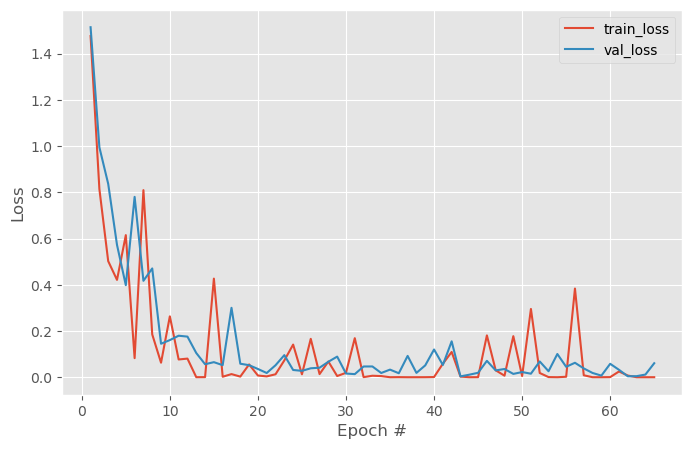

In [32]:
Drawloss(loss_list, val_loss_list)

In [33]:
# torch.save(model, model_path)
val_accuracy(model_path)
test_result(model_path, predict_csv_path)

100%|██████████| 8/8 [00:01<00:00,  4.74it/s]


/kaggle/working/PSPNetDeeper_epoch100_kaggle.pt, Val Accuracy: 99.60%


100%|██████████| 10142/10142 [01:07<00:00, 150.19it/s]


## 2.5 PSPNet + GLCM features

In [12]:
model_path = f'/kaggle/working/PSPNetGLCM_epoch{EPOCHS}_kaggle.pt'
predict_csv_path = f'/kaggle/working/PSPNetGLCM_epoch{EPOCHS}_kaggle.csv'

In [22]:
def GLCM_features(image):
    image = np.array(image)
    image = (image * 255).astype(np.uint8)
    glcm_features = torch.empty(25, dtype=torch.float32)

    #5 configuration for the grey-level co-occurrence matrix calculation
    dists = [[1],[3],[5],[3],[3]]
    angles = [[0],[0],[0],[np.pi/4],[np.pi/2]]

    for j ,(dist, angle) in enumerate(zip(dists, angles)):
        GLCM = graycomatrix(image, dist, angle) 
        glcm_features[j*5] = torch.tensor(graycoprops(GLCM, 'energy')[0], dtype=torch.float32)
        glcm_features[j*5 + 1] = torch.tensor(graycoprops(GLCM, 'correlation')[0] , dtype=torch.float32)   
        glcm_features[j*5 + 2] = torch.tensor(graycoprops(GLCM, 'dissimilarity')[0], dtype=torch.float32)
        glcm_features[j*5 + 3] = torch.tensor(graycoprops(GLCM, 'homogeneity')[0], dtype=torch.float32)
        glcm_features[j*5 + 4] = torch.tensor(graycoprops(GLCM, 'contrast')[0], dtype=torch.float32)
        
    return glcm_features

In [19]:
class GLCMDataset(Dataset):
    def __init__(self, csv_path, images_folder, transform = False):
        self.df = pd.read_csv(csv_path)
        self.images_folder = images_folder
        self.transform = transform

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        filename = self.df.loc[index, "ID"]
        label = self.df.loc[index, "Label"].item()
        image = Image.open(os.path.join(self.images_folder, filename))
        glcm_feature = GLCM_features(image)
        if self.transform:
            image = self.transform(image)
        return image, label, glcm_feature

In [20]:
dataset = GLCMDataset('/kaggle/input/csv-index/train.csv','/kaggle/input/train-image-aoi/train_images', transform=transform)
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [0.9, 0.1])
test_dataset = GLCMDataset('/kaggle/input/csv-index/test.csv','/kaggle/input/test-image-aoi/test_images', transform=test_transform)

val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [23]:
for images, labels, glcm_features in train_dataloader:
    print(images.shape)
    print(labels.shape)
    print(glcm_features.shape)
    break

torch.Size([32, 1, 512, 512])
torch.Size([32])
torch.Size([32, 25])


In [17]:
class PSPNetGLCM(nn.Module):
    def __init__(self, num_classes):
        super(PSPNetGLCM, self).__init__()
        
        # Conv layers
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1), # output size (N, 16, 512, 512)
            nn.ReLU(),
            nn.MaxPool2d(2), # output size (N, 16, 256, 256)
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1), # output size (N, 32, 256, 256)
            nn.ReLU(),
            nn.MaxPool2d(2), # output size (N, 32, 128, 128)
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1), # output size (N, 64, 128, 128)
            nn.ReLU(),
            nn.MaxPool2d(2), # output size (N, 64, 64, 64)
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1), # output size (N, 128, 64, 64)
            nn.ReLU(),
            nn.MaxPool2d(2), # output size (N, 128, 32, 32)
        )
        # Spatial Pyramid Pooling layers
        self.pool1 = nn.AdaptiveMaxPool2d((1, 1)) # output size (N, 64, 1, 1)
        self.pool2 = nn.AdaptiveMaxPool2d((2, 2)) # output size (N, 64, 2, 2)
        self.pool3 = nn.AdaptiveMaxPool2d((3, 3)) # output size (N, 64, 3, 3)
        self.pool4 = nn.AdaptiveMaxPool2d((6, 6)) # output size (N, 64, 6, 6)
        self.con1 = nn.Conv2d(in_channels=128, out_channels=1, kernel_size=1, stride=1, padding=0) # output size (N, 1, 1, 1)
        self.con2 = nn.Conv2d(in_channels=128, out_channels=1, kernel_size=1, stride=1, padding=0) # output size (N, 1, 2, 2)
        self.con3 = nn.Conv2d(in_channels=128, out_channels=1, kernel_size=1, stride=1, padding=0) # output size (N, 1, 3, 3)
        self.con4 = nn.Conv2d(in_channels=128, out_channels=1, kernel_size=1, stride=1, padding=0) # output size (N, 1, 6, 6)
        # Upsampling layers
        self.upsample1 = nn.Upsample(scale_factor=32/1, mode='bilinear', align_corners=True) # output size (N, 1, 32, 32)
        self.upsample2 = nn.Upsample(scale_factor=32/2, mode='bilinear', align_corners=True) # output size (N, 1, 32, 32)
        self.upsample3 = nn.Upsample(scale_factor=32/3, mode='bilinear', align_corners=True) # output size (N, 1, 32, 32)
        self.upsample4 = nn.Upsample(scale_factor=32/6, mode='bilinear', align_corners=True) # output size (N, 1, 32, 32)
        
        # Conv Classifier layers
        self.nn_classifier = nn.Sequential(
            nn.Conv2d(in_channels=132, out_channels=64, kernel_size=3, stride=2, padding=1), # output size (N, 64, 16, 16)
            nn.ReLU(),
            nn.MaxPool2d(2), # output size (N, 64, 8, 8)
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, stride=2, padding=1), # output size (N, 32, 4, 4)
            nn.ReLU(),
            nn.MaxPool2d(2), # output size (N, 32, 2, 2)
            nn.Flatten(), # output size (N, 32 * 2* 2)
            nn.Linear(32 * 2 * 2, 24), # output size (N, 24)
            nn.ReLU(),
        )
        self.glcm_classifier= nn.Sequential(
            nn.Linear(25, 8), # output size (N, 8)
            nn.ReLU(),
        )
        self.final_classifier = nn.Sequential(
            nn.Linear(32, num_classes) # output size (N, num_classes=6)
        )
        
    def forward(self, x_input, x_glcm):
        # CNN layers
        x = self.features(x_input)
        
        # Spatial Pyramid Pooling
        x1 = self.pool1(x)
        x1 = self.con1(x1) 
        x2 = self.pool2(x)
        x2 = self.con2(x2)
        x3 = self.pool3(x)
        x3 = self.con3(x3)
        x4 = self.pool4(x)
        x4 = self.con4(x4)
        
        # Upsampling
        x1 = self.upsample1(x1)
        x2 = self.upsample2(x2)
        x3 = self.upsample3(x3)
        x4 = self.upsample4(x4)
        
        # Concatenate the pooled features
        x = torch.cat((x1, x2, x3, x4, x), dim=1) # output size (N, 132, 32, 32)
        
        # Classifier
        x = self.nn_classifier(x) # output size (N, 24)
        
        # Get GLCM features 
        x_glcm = self.glcm_classifier(x_glcm) # output size (N, 8)
        
        # Concatenate nn features and GLCM features
        x = torch.cat((x, x_glcm), dim=1) # output size (N, 32, 32)
        
        # final classifier
        x = self.final_classifier(x)
        
        return x

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PSPNetGLCM(num_classes=6).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

loss_list = []
val_loss_list = []
early_stopper = EarlyStopper(model_path = model_path)

for epoch in range(EPOCHS):
    model.train()
    for images, labels, glcm_features in tqdm(train_dataloader):
        images = images.to(device)
        labels = labels.to(device)
        glcm_features = glcm_features.to(device)
        
        optimizer.zero_grad()
        outputs = model(images, glcm_features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    loss_list.append(loss.item())
    
    model.eval()
    with torch.no_grad():
        tmp_loss_list = []
        for images, labels, glcm_features in val_dataloader:
            images = images.to(device)
            labels = labels.to(device)
            glcm_features = glcm_features.to(device)
            
            outputs = model(images, glcm_features)
            val_loss = criterion(outputs, labels)
            tmp_loss_list.append(val_loss.item())
        avg_val_loss = sum(tmp_loss_list)/len(tmp_loss_list)
        val_loss_list.append(avg_val_loss)
        if early_stopper.check(avg_val_loss, model):
            print(f'Epoch [{epoch+1}/{EPOCHS}], Train Loss: {loss.item():.4f}, Val Loss:{avg_val_loss:.4f},\nEarly stop in {epoch+1}!!')
            break
            
    if (epoch+1) % 1 == 0 or epoch == 0:
        print(f'Epoch [{epoch+1}/{EPOCHS}], Train Loss: {loss.item():.4f}, Val Loss:{avg_val_loss:.4f}')

100%|██████████| 72/72 [01:02<00:00,  1.15it/s]


Epoch [1/100], Train Loss: 0.9563, Val Loss:1.3816


100%|██████████| 72/72 [01:04<00:00,  1.12it/s]


Epoch [2/100], Train Loss: 2.1014, Val Loss:1.0265


100%|██████████| 72/72 [01:04<00:00,  1.12it/s]


Epoch [3/100], Train Loss: 0.6420, Val Loss:0.9847


100%|██████████| 72/72 [01:04<00:00,  1.11it/s]


Epoch [4/100], Train Loss: 1.2981, Val Loss:0.8223


100%|██████████| 72/72 [01:05<00:00,  1.11it/s]


Epoch [5/100], Train Loss: 0.6173, Val Loss:0.5201


100%|██████████| 72/72 [01:03<00:00,  1.14it/s]


Epoch [6/100], Train Loss: 0.2521, Val Loss:0.2978


100%|██████████| 72/72 [01:04<00:00,  1.12it/s]


Epoch [7/100], Train Loss: 0.2267, Val Loss:0.3616


100%|██████████| 72/72 [01:03<00:00,  1.14it/s]


Epoch [8/100], Train Loss: 0.0739, Val Loss:0.3097


100%|██████████| 72/72 [01:03<00:00,  1.14it/s]


Epoch [9/100], Train Loss: 0.1017, Val Loss:0.2353


100%|██████████| 72/72 [01:03<00:00,  1.14it/s]


Epoch [10/100], Train Loss: 0.0933, Val Loss:0.1733


100%|██████████| 72/72 [01:03<00:00,  1.13it/s]


Epoch [11/100], Train Loss: 0.4360, Val Loss:0.2116


100%|██████████| 72/72 [01:02<00:00,  1.16it/s]


Epoch [12/100], Train Loss: 0.0735, Val Loss:0.1576


100%|██████████| 72/72 [01:02<00:00,  1.15it/s]


Epoch [13/100], Train Loss: 0.1954, Val Loss:0.1906


100%|██████████| 72/72 [01:01<00:00,  1.17it/s]


Epoch [14/100], Train Loss: 0.2217, Val Loss:0.1477


100%|██████████| 72/72 [01:01<00:00,  1.18it/s]


Epoch [15/100], Train Loss: 0.1350, Val Loss:0.1411


100%|██████████| 72/72 [01:01<00:00,  1.16it/s]


Epoch [16/100], Train Loss: 0.0696, Val Loss:0.1565


100%|██████████| 72/72 [01:01<00:00,  1.16it/s]


Epoch [17/100], Train Loss: 0.0543, Val Loss:0.1289


100%|██████████| 72/72 [01:00<00:00,  1.19it/s]


Epoch [18/100], Train Loss: 0.1068, Val Loss:0.1254


100%|██████████| 72/72 [01:01<00:00,  1.17it/s]


Epoch [19/100], Train Loss: 0.0027, Val Loss:0.1808


100%|██████████| 72/72 [01:01<00:00,  1.18it/s]


Epoch [20/100], Train Loss: 0.0403, Val Loss:0.1104


100%|██████████| 72/72 [01:01<00:00,  1.18it/s]


Epoch [21/100], Train Loss: 0.0027, Val Loss:0.0853


100%|██████████| 72/72 [01:02<00:00,  1.16it/s]


Epoch [22/100], Train Loss: 0.0032, Val Loss:0.1201


100%|██████████| 72/72 [01:01<00:00,  1.18it/s]


Epoch [23/100], Train Loss: 0.0122, Val Loss:0.1123


100%|██████████| 72/72 [01:01<00:00,  1.18it/s]


Epoch [24/100], Train Loss: 0.0010, Val Loss:0.0888


100%|██████████| 72/72 [01:01<00:00,  1.18it/s]


Epoch [25/100], Train Loss: 0.0422, Val Loss:0.1197


100%|██████████| 72/72 [01:01<00:00,  1.18it/s]


Epoch [26/100], Train Loss: 0.0315, Val Loss:0.0725


100%|██████████| 72/72 [01:01<00:00,  1.18it/s]


Epoch [27/100], Train Loss: 0.0085, Val Loss:0.1293


100%|██████████| 72/72 [01:00<00:00,  1.18it/s]


Epoch [28/100], Train Loss: 0.0002, Val Loss:0.1306


100%|██████████| 72/72 [01:01<00:00,  1.18it/s]


Epoch [29/100], Train Loss: 0.0540, Val Loss:0.0755


100%|██████████| 72/72 [01:01<00:00,  1.18it/s]


Epoch [30/100], Train Loss: 0.0001, Val Loss:0.0613


100%|██████████| 72/72 [01:01<00:00,  1.18it/s]


Epoch [31/100], Train Loss: 0.0390, Val Loss:0.0701


100%|██████████| 72/72 [01:00<00:00,  1.18it/s]


Epoch [32/100], Train Loss: 0.0008, Val Loss:0.1121


100%|██████████| 72/72 [01:01<00:00,  1.18it/s]


Epoch [33/100], Train Loss: 0.0034, Val Loss:0.1248


100%|██████████| 72/72 [01:02<00:00,  1.15it/s]


Epoch [34/100], Train Loss: 0.0254, Val Loss:0.0597


100%|██████████| 72/72 [01:02<00:00,  1.15it/s]


Epoch [35/100], Train Loss: 0.0021, Val Loss:0.2052


100%|██████████| 72/72 [01:05<00:00,  1.11it/s]


Epoch [36/100], Train Loss: 0.0001, Val Loss:0.0434


100%|██████████| 72/72 [01:05<00:00,  1.10it/s]


Epoch [37/100], Train Loss: 0.3819, Val Loss:0.0806


100%|██████████| 72/72 [01:02<00:00,  1.15it/s]


Epoch [38/100], Train Loss: 0.3874, Val Loss:0.0980


100%|██████████| 72/72 [01:02<00:00,  1.16it/s]


Epoch [39/100], Train Loss: 0.5041, Val Loss:0.2464


100%|██████████| 72/72 [01:02<00:00,  1.15it/s]


Epoch [40/100], Train Loss: 0.0074, Val Loss:0.0908


100%|██████████| 72/72 [01:02<00:00,  1.16it/s]


Epoch [41/100], Train Loss: 0.0657, Val Loss:0.1157


100%|██████████| 72/72 [01:02<00:00,  1.15it/s]


Epoch [42/100], Train Loss: 0.0120, Val Loss:0.0519


100%|██████████| 72/72 [01:02<00:00,  1.15it/s]


Epoch [43/100], Train Loss: 0.0004, Val Loss:0.1035


100%|██████████| 72/72 [01:02<00:00,  1.16it/s]


Epoch [44/100], Train Loss: 0.0010, Val Loss:0.0622


100%|██████████| 72/72 [01:02<00:00,  1.16it/s]


Epoch [45/100], Train Loss: 0.0080, Val Loss:0.0576


100%|██████████| 72/72 [01:03<00:00,  1.14it/s]


Epoch [46/100], Train Loss: 0.0020, Val Loss:0.0642


100%|██████████| 72/72 [01:03<00:00,  1.13it/s]


Epoch [47/100], Train Loss: 0.1397, Val Loss:0.0779


100%|██████████| 72/72 [01:03<00:00,  1.14it/s]


Epoch [48/100], Train Loss: 0.0016, Val Loss:0.0392


100%|██████████| 72/72 [01:02<00:00,  1.14it/s]


Epoch [49/100], Train Loss: 0.0026, Val Loss:0.0606


100%|██████████| 72/72 [01:02<00:00,  1.14it/s]


Epoch [50/100], Train Loss: 0.0003, Val Loss:0.1149


100%|██████████| 72/72 [01:03<00:00,  1.13it/s]


Epoch [51/100], Train Loss: 0.0307, Val Loss:0.0742


100%|██████████| 72/72 [01:02<00:00,  1.16it/s]


Epoch [52/100], Train Loss: 0.0178, Val Loss:0.0408


100%|██████████| 72/72 [01:01<00:00,  1.16it/s]


Epoch [53/100], Train Loss: 0.2806, Val Loss:0.0851


100%|██████████| 72/72 [01:02<00:00,  1.16it/s]


Epoch [54/100], Train Loss: 0.0020, Val Loss:0.0569


100%|██████████| 72/72 [01:02<00:00,  1.16it/s]


Epoch [55/100], Train Loss: 0.0000, Val Loss:0.0562


100%|██████████| 72/72 [01:02<00:00,  1.14it/s]


Epoch [56/100], Train Loss: 0.0000, Val Loss:0.0460


100%|██████████| 72/72 [01:03<00:00,  1.14it/s]


Epoch [57/100], Train Loss: 0.0001, Val Loss:0.0295


100%|██████████| 72/72 [01:02<00:00,  1.16it/s]


Epoch [58/100], Train Loss: 0.0001, Val Loss:0.0275


100%|██████████| 72/72 [01:02<00:00,  1.15it/s]


Epoch [59/100], Train Loss: 0.0067, Val Loss:0.0298


100%|██████████| 72/72 [01:02<00:00,  1.16it/s]


Epoch [60/100], Train Loss: 0.0054, Val Loss:0.0607


100%|██████████| 72/72 [01:02<00:00,  1.15it/s]


Epoch [61/100], Train Loss: 0.0001, Val Loss:0.0446


100%|██████████| 72/72 [01:01<00:00,  1.18it/s]


Epoch [62/100], Train Loss: 0.0011, Val Loss:0.0521


100%|██████████| 72/72 [01:01<00:00,  1.17it/s]


Epoch [63/100], Train Loss: 0.0000, Val Loss:0.0963


100%|██████████| 72/72 [01:01<00:00,  1.17it/s]


Epoch [64/100], Train Loss: 0.0107, Val Loss:0.0327


100%|██████████| 72/72 [01:01<00:00,  1.16it/s]


Epoch [65/100], Train Loss: 0.0006, Val Loss:0.1349


100%|██████████| 72/72 [01:06<00:00,  1.09it/s]


Epoch [66/100], Train Loss: 0.0022, Val Loss:0.0444


100%|██████████| 72/72 [01:04<00:00,  1.12it/s]


Epoch [67/100], Train Loss: 0.0527, Val Loss:0.0434


100%|██████████| 72/72 [01:02<00:00,  1.15it/s]


Epoch [68/100], Train Loss: 0.0000, Val Loss:0.0563


100%|██████████| 72/72 [01:02<00:00,  1.15it/s]


Epoch [69/100], Train Loss: 0.0000, Val Loss:0.1708


100%|██████████| 72/72 [01:02<00:00,  1.16it/s]


Epoch [70/100], Train Loss: 0.0002, Val Loss:0.0678


100%|██████████| 72/72 [01:02<00:00,  1.15it/s]


Epoch [71/100], Train Loss: 0.0058, Val Loss:0.0511


100%|██████████| 72/72 [01:02<00:00,  1.15it/s]


Epoch [72/100], Train Loss: 0.0587, Val Loss:0.0460


100%|██████████| 72/72 [01:02<00:00,  1.15it/s]


Epoch [73/100], Train Loss: 0.0000, Val Loss:0.0827


100%|██████████| 72/72 [01:04<00:00,  1.12it/s]


Epoch [74/100], Train Loss: 0.0233, Val Loss:0.0610


100%|██████████| 72/72 [01:03<00:00,  1.13it/s]


Epoch [75/100], Train Loss: 0.0001, Val Loss:0.1069


100%|██████████| 72/72 [01:03<00:00,  1.13it/s]


Epoch [76/100], Train Loss: 0.0049, Val Loss:0.0617


100%|██████████| 72/72 [01:03<00:00,  1.13it/s]


Epoch [77/100], Train Loss: 0.0003, Val Loss:0.0221


100%|██████████| 72/72 [01:04<00:00,  1.12it/s]


Epoch [78/100], Train Loss: 0.0128, Val Loss:0.0759


100%|██████████| 72/72 [01:03<00:00,  1.13it/s]


Epoch [79/100], Train Loss: 0.0005, Val Loss:0.0277


100%|██████████| 72/72 [01:03<00:00,  1.13it/s]


Epoch [80/100], Train Loss: 0.0003, Val Loss:0.0277


100%|██████████| 72/72 [01:04<00:00,  1.12it/s]


Epoch [81/100], Train Loss: 0.0000, Val Loss:0.1208


100%|██████████| 72/72 [01:03<00:00,  1.13it/s]


Epoch [82/100], Train Loss: 0.0004, Val Loss:0.0477


100%|██████████| 72/72 [01:03<00:00,  1.13it/s]


Epoch [83/100], Train Loss: 0.0001, Val Loss:0.0448


100%|██████████| 72/72 [01:03<00:00,  1.13it/s]


Epoch [84/100], Train Loss: 0.0000, Val Loss:0.0620


100%|██████████| 72/72 [01:04<00:00,  1.12it/s]


Epoch [85/100], Train Loss: 0.0004, Val Loss:0.0556


100%|██████████| 72/72 [01:03<00:00,  1.13it/s]


Epoch [86/100], Train Loss: 0.1459, Val Loss:0.1059


100%|██████████| 72/72 [01:03<00:00,  1.13it/s]


Epoch [87/100], Train Loss: 0.2848, Val Loss:0.0524


100%|██████████| 72/72 [01:03<00:00,  1.13it/s]


Epoch [88/100], Train Loss: 0.0030, Val Loss:0.0535


100%|██████████| 72/72 [01:03<00:00,  1.13it/s]


Epoch [89/100], Train Loss: 0.0000, Val Loss:0.0675


100%|██████████| 72/72 [01:03<00:00,  1.13it/s]


Epoch [90/100], Train Loss: 0.0002, Val Loss:0.0308


100%|██████████| 72/72 [01:03<00:00,  1.14it/s]


Epoch [91/100], Train Loss: 0.0003, Val Loss:0.0665


100%|██████████| 72/72 [01:03<00:00,  1.14it/s]


Epoch [92/100], Train Loss: 0.0008, Val Loss:0.0688


100%|██████████| 72/72 [01:03<00:00,  1.13it/s]


Epoch [93/100], Train Loss: 0.0000, Val Loss:0.2127


100%|██████████| 72/72 [01:05<00:00,  1.10it/s]


Epoch [94/100], Train Loss: 0.0152, Val Loss:0.0615


100%|██████████| 72/72 [01:06<00:00,  1.08it/s]


Epoch [95/100], Train Loss: 0.0115, Val Loss:0.0235


100%|██████████| 72/72 [01:05<00:00,  1.09it/s]


Epoch [96/100], Train Loss: 0.0001, Val Loss:0.0458


100%|██████████| 72/72 [01:04<00:00,  1.12it/s]


Epoch [97/100], Train Loss: 0.0091, Val Loss:0.0374,
Early stop in 97!!


In [24]:
def val_accuracy(model_path):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if device.type == 'cuda':
        model = torch.load(model_path)
    else:
        model = torch.load(model_path, map_location=torch.device('cpu'))
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels, glcm_features in tqdm(val_dataloader):
            images = images.to(device)
            labels = labels.to(device)
            glcm_features = glcm_features.to(device)
            
            outputs = model(images, glcm_features)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        accuracy = 100 * correct / total
        print(f"{model_path}, Val Accuracy: {accuracy:.2f}%")

In [25]:
def test_result(model_path, csv_filename):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if device.type == 'cuda':
        model = torch.load(model_path)
    else:
        model = torch.load(model_path, map_location=torch.device('cpu'))
    model.eval()
    correct = 0
    total = 0
    predicted_list = []
    with torch.no_grad():
        for images, labels, glcm_features in tqdm(test_dataloader):
            images = images.to(device)
            labels = labels.to(device)
            glcm_features = glcm_features.to(device)
            
            outputs = model(images, glcm_features)
            _, predicted = torch.max(outputs.data, 1)
            predicted_list.append(predicted.item())
            
    test_df['Label'] = predicted_list
    test_df.to_csv(f'{csv_filename}', index=False)

In [27]:
# Drawloss(loss_list, val_loss_list)
val_accuracy(model_path)
test_result(model_path, predict_csv_path)

100%|██████████| 8/8 [00:12<00:00,  1.57s/it]


/kaggle/input/glcmmodel/PSPNetGLCM_epoch100_kaggle.pt, Val Accuracy: 98.81%


100%|██████████| 10142/10142 [05:29<00:00, 30.80it/s]


## 3. Baseline
> second best, In feature layer, channels number half is better. Half score(16->32):0.9528976,Full score(32->64):0.9418002
- extract feature based on Conv
- Linear to classify
- all from scratch

In [34]:
model_path = f'/kaggle/working/BaseDeeper_epoch{EPOCHS}_kaggle.pt'
predict_csv_path = f'/kaggle/working/BaseDeeper_epoch{EPOCHS}_kaggle.csv'

In [35]:
class BasicCNN(nn.Module):
    def __init__(self, num_classes):
        super(BasicCNN, self).__init__()
        
        # Conv layers
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1), # output size (N, 16, 512, 512)
            nn.ReLU(),
            nn.MaxPool2d(2), # output size (N, 16, 256, 256)
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1), # output size (N, 32, 256, 256)
            nn.ReLU(),
            nn.MaxPool2d(2), # output size (N, 32, 128, 128)
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1), # output size (N, 64, 128, 128)
            nn.ReLU(),
            nn.MaxPool2d(2), # output size (N, 64, 64, 64)
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1), # output size (N, 128, 64, 64)
            nn.ReLU(),
            nn.MaxPool2d(2), # output size (N, 128, 32, 32)
        )
        # Conv Classifier layers
        self.classifier = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1), # output size (N, 64, 16, 16)
            nn.ReLU(),
            nn.MaxPool2d(2), # output size (N, 64, 8, 8)
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, stride=2, padding=1), # output size (N, 32, 4, 4)
            nn.ReLU(),
            nn.MaxPool2d(2), # output size (N, 32, 2, 2)
            nn.Flatten(), # output size (N, 32 * 2* 2)
            nn.Linear(32 * 2 * 2, 32), # output size (N, 32)
            nn.ReLU(),
            nn.Linear(32, num_classes), # output size (N, 6)
        )
        
    def forward(self, x):
        # CNN layers
        x = self.features(x)
        x = self.classifier(x)
        return x

In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BasicCNN(num_classes=6).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

loss_list = []
val_loss_list = []
early_stopper = EarlyStopper(model_path = model_path)

for epoch in range(EPOCHS):
    model.train()
    for images, labels in train_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    loss_list.append(loss.item())
    
    model.eval()
    with torch.no_grad():
        tmp_loss_list = []
        for images, labels in val_dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            val_loss = criterion(outputs, labels)
            tmp_loss_list.append(val_loss.item())
        avg_val_loss = sum(tmp_loss_list)/len(tmp_loss_list)
        val_loss_list.append(avg_val_loss)
        if early_stopper.check(avg_val_loss, model):
            print(f'Epoch [{epoch+1}/{EPOCHS}], Train Loss: {loss.item():.4f}, Val Loss:{avg_val_loss:.4f},\nEarly stop in {epoch+1}!!')
            break
            
    if (epoch+1) % 1 == 0 or epoch == 0:
        print(f'Epoch [{epoch+1}/{EPOCHS}], Train Loss: {loss.item():.4f}, Val Loss:{avg_val_loss:.4f}')

Epoch [1/100], Train Loss: 1.7418, Val Loss:1.6917
Epoch [2/100], Train Loss: 0.8336, Val Loss:1.4238
Epoch [3/100], Train Loss: 1.1978, Val Loss:0.9455
Epoch [4/100], Train Loss: 0.9695, Val Loss:0.8317
Epoch [5/100], Train Loss: 0.4658, Val Loss:0.6571
Epoch [6/100], Train Loss: 0.3311, Val Loss:0.8389
Epoch [7/100], Train Loss: 0.7668, Val Loss:0.4046
Epoch [8/100], Train Loss: 0.0604, Val Loss:0.3740
Epoch [9/100], Train Loss: 0.0898, Val Loss:0.4669
Epoch [10/100], Train Loss: 0.6569, Val Loss:0.3632
Epoch [11/100], Train Loss: 1.6781, Val Loss:0.2598
Epoch [12/100], Train Loss: 0.0248, Val Loss:0.3012
Epoch [13/100], Train Loss: 0.0077, Val Loss:0.1985
Epoch [14/100], Train Loss: 0.8430, Val Loss:0.1613
Epoch [15/100], Train Loss: 0.0308, Val Loss:0.1483
Epoch [16/100], Train Loss: 0.2709, Val Loss:0.2511
Epoch [17/100], Train Loss: 0.0511, Val Loss:0.1617
Epoch [18/100], Train Loss: 0.0724, Val Loss:0.1632
Epoch [19/100], Train Loss: 0.0048, Val Loss:0.1518
Epoch [20/100], Train

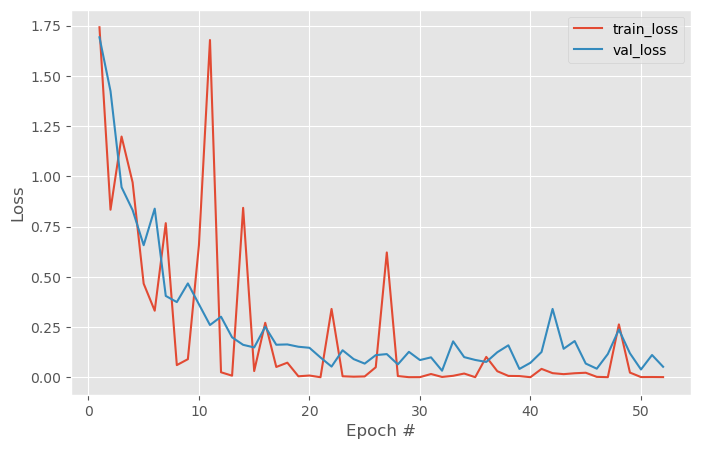

100%|██████████| 8/8 [00:01<00:00,  5.22it/s]


/kaggle/working/BaseDeeper_epoch100_kaggle.pt, Val Accuracy: 98.02%


100%|██████████| 10142/10142 [01:07<00:00, 151.16it/s]


In [37]:
Drawloss(loss_list, val_loss_list)
val_accuracy(model_path)
test_result(model_path, predict_csv_path)

## 4. ResNet 18
> The worst no need to submit
- first layer 3 channels change to 1 channel
- last append a new linear 
    - input size 1000 
    - output size class_num=6
- only train above 2 layers, other layer use pretrained ResNet18

In [128]:
# # 檢視 ResNet18 模型結構
# net = models.resnet18()
# print(net)

In [129]:
model_path = f'/kaggle/working/ResNet18_epoch{EPOCHS}_kaggle.pt'
predict_csv_path = f'/kaggle/working/ResNet18_epoch{EPOCHS}_kaggle.pt'

In [130]:
class ResNet(nn.Module):
    def __init__(self, num_classes):
        super(ResNet, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        
        # Modify the first layer to accept single-channel input
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        # Freeze the layers except the new conv1 and the classification layer
        for name, param in self.resnet.named_parameters():
            if 'conv1' in name:
                param.requires_grad = True
            else:
                param.requires_grad = False
        
        # Modify the classification layer
        self.classifier = nn.Linear(self.resnet.fc.out_features, num_classes)
        
    def forward(self, x):
        x = self.resnet(x)
        x = self.classifier(x)
        return x

In [131]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Define the model
num_classes = 6
model = ResNet(num_classes).to(device)

criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
# Define the optimizer for fine-tuning using Adam with a single learning rate
fine_tune_params = list(model.resnet.conv1.parameters()) + list(model.classifier.parameters())
optimizer = torch.optim.Adam(fine_tune_params, lr=0.001, betas=(0.9, 0.999))

loss_list = []
val_loss_list = []
early_stopper = EarlyStopper(model_path = model_path)

for epoch in range(EPOCHS):
    model.train()
    for images, labels in train_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    loss_list.append(loss.item())
    
    model.eval()
    with torch.no_grad():
        tmp_loss_list = []
        for images, labels in val_dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            val_loss = criterion(outputs, labels)
            tmp_loss_list.append(val_loss.item())
        avg_val_loss = sum(tmp_loss_list)/len(tmp_loss_list)
        val_loss_list.append(avg_val_loss)
        if early_stopper.check(avg_val_loss, model):
            print(f'Epoch [{epoch+1}/{EPOCHS}], Train Loss: {loss.item():.4f}, Val Loss:{avg_val_loss:.4f},\nEarly stop in {epoch+1}!!')
            break
            
    if (epoch+1) % 1 == 0 or epoch == 0:
        print(f'Epoch [{epoch+1}/{EPOCHS}], Train Loss: {loss.item():.4f}, Val Loss:{avg_val_loss:.4f}')

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/100], Train Loss: 1.1159, Val Loss:1.6740
Epoch [2/100], Train Loss: 2.2667, Val Loss:2.7956
Epoch [3/100], Train Loss: 1.1289, Val Loss:1.2379
Epoch [4/100], Train Loss: 0.9062, Val Loss:0.8075
Epoch [5/100], Train Loss: 0.2080, Val Loss:0.7813
Epoch [6/100], Train Loss: 0.0084, Val Loss:2.5921
Epoch [7/100], Train Loss: 0.2080, Val Loss:2.7423
Epoch [8/100], Train Loss: 0.0336, Val Loss:3.4079
Epoch [9/100], Train Loss: 2.0232, Val Loss:1.6156
Epoch [10/100], Train Loss: 0.0729, Val Loss:0.4063
Epoch [11/100], Train Loss: 1.7058, Val Loss:3.1305
Epoch [12/100], Train Loss: 0.3574, Val Loss:0.7805
Epoch [13/100], Train Loss: 0.1662, Val Loss:0.5514
Epoch [14/100], Train Loss: 0.2310, Val Loss:1.2254
Epoch [15/100], Train Loss: 1.6394, Val Loss:0.4862
Epoch [16/100], Train Loss: 1.7020, Val Loss:4.4779
Epoch [17/100], Train Loss: 0.0730, Val Loss:2.2311
Epoch [18/100], Train Loss: 0.1184, Val Loss:3.4166
Epoch [19/100], Train Loss: 0.0085, Val Loss:1.2620
Epoch [20/100], Train

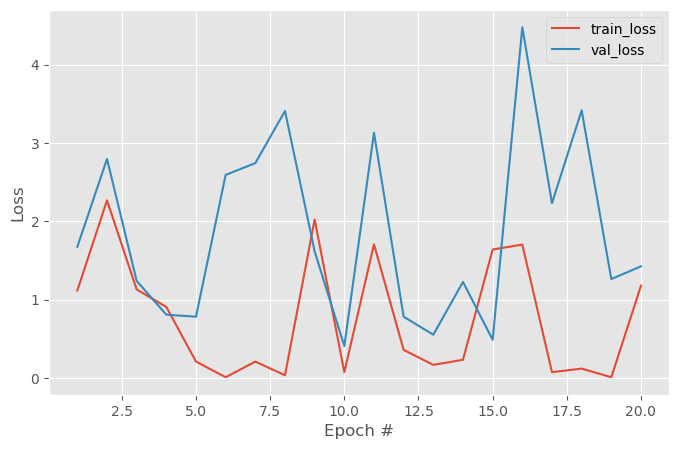

100%|██████████| 8/8 [00:01<00:00,  4.58it/s]


/kaggle/working/ResNet18_epoch100_kaggle.pt, Val Accuracy: 75.40%


100%|██████████| 10142/10142 [01:22<00:00, 123.63it/s]


In [132]:
Drawloss(loss_list, val_loss_list)
val_accuracy(model_path)
test_result(model_path, predict_csv_path)

## 5. ResNet18 with PSPNet idea
> score: 0.9420468, worse then all from scratch
- first layer 3 channels change to 1 channel
- last append Pyramid Pooling layers, Onebyone Conv and Upsampling before ResNet18 layer4
- Conv + Linear to classify
- Train above 3 layers, other layer use pretrained ResNet18

In [117]:
model_path = f'/kaggle/working/ResNetPSPNet_epoch{EPOCHS}_kaggle.pt'
predict_csv_path = f'/kaggle/working/ResNetPSPNet_epoch{EPOCHS}_kaggle.csv'

In [118]:
class ResNetPSPNet(nn.Module):
    def __init__(self, num_classes):
        super(ResNetPSPNet, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        
        # Modify the first layer to accept single-channel input
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        # Freeze the layers except the new conv1 and the classification layer
        for name, param in self.resnet.named_parameters():
            if 'conv1' in name:
                param.requires_grad = True
            else:
                param.requires_grad = False
        
        # Spatial Pyramid Pooling layers
        self.pool1 = nn.AdaptiveMaxPool2d((1, 1)) # output size (N, 512, 1, 1)
        self.pool2 = nn.AdaptiveMaxPool2d((2, 2)) # output size (N, 512, 2, 2)
        self.pool3 = nn.AdaptiveMaxPool2d((3, 3)) # output size (N, 512, 3, 3)
        self.pool4 = nn.AdaptiveMaxPool2d((6, 6)) # output size (N, 512, 6, 6)
        self.onebyonecon1 = nn.Conv2d(in_channels=512, out_channels=1, kernel_size=1, stride=1, padding=0) # output size (N, 1, 1, 1)
        self.onebyonecon2 = nn.Conv2d(in_channels=512, out_channels=1, kernel_size=1, stride=1, padding=0) # output size (N, 1, 2, 2)
        self.onebyonecon3 = nn.Conv2d(in_channels=512, out_channels=1, kernel_size=1, stride=1, padding=0) # output size (N, 1, 3, 3)
        self.onebyonecon4 = nn.Conv2d(in_channels=512, out_channels=1, kernel_size=1, stride=1, padding=0) # output size (N, 1, 6, 6)
        # Upsampling layers
        self.upsample1 = nn.Upsample(scale_factor=16/1, mode='bilinear', align_corners=True) # output size (N, 1, 16, 16)
        self.upsample2 = nn.Upsample(scale_factor=16/2, mode='bilinear', align_corners=True) # output size (N, 1, 16, 16)
        self.upsample3 = nn.Upsample(scale_factor=16/3, mode='bilinear', align_corners=True) # output size (N, 1, 16, 16)
        self.upsample4 = nn.Upsample(scale_factor=16/6, mode='bilinear', align_corners=True) # output size (N, 1, 16, 16)
        # Conv Classifier layers
        self.classifier = nn.Sequential(
            nn.Conv2d(in_channels=516, out_channels=128, kernel_size=3, stride=2, padding=1), # output size (N, 128, 8, 8)
            nn.ReLU(),
            nn.MaxPool2d(2), # output size (N, 128, 4, 4)
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1), # output size (N, 64, 2, 2)
            nn.ReLU(),
            nn.MaxPool2d(2), # output size (N, 64, 1, 1)
            nn.Flatten(), # output size (N, 64 * 1 * 1)
            nn.Linear(64, num_classes), # output size (N, 6)
        )
        
    def forward(self, x):
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)

        x = self.resnet.layer1(x)
        x = self.resnet.layer2(x)
        x = self.resnet.layer3(x)
        x = self.resnet.layer4(x)
        
        # Spatial Pyramid Pooling
        x1 = self.pool1(x)
        x1 = self.onebyonecon1(x1) 
        x2 = self.pool2(x)
        x2 = self.onebyonecon2(x2)
        x3 = self.pool3(x)
        x3 = self.onebyonecon3(x3)
        x4 = self.pool4(x)
        x4 = self.onebyonecon4(x4)
        
        # Upsampling
        x1 = self.upsample1(x1)
        x2 = self.upsample2(x2)
        x3 = self.upsample3(x3)
        x4 = self.upsample4(x4)
        
        # Concatenate the pooled features
        x = torch.cat((x1, x2, x3, x4, x), dim=1) # output size (N, 516, 16, 16)
        
        # Classifier
        x = self.classifier(x)
        
        return x

In [119]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Define the model
num_classes = 6
model = ResNetPSPNet(num_classes).to(device)

criterion = nn.CrossEntropyLoss()
# Define the optimizer for fine-tuning using Adam with a single learning rate

# Create a list of parameters to optimize (conv1 and classifier)
parameters_to_optimize = [
    {'params': model.resnet.conv1.parameters()},
    {'params': model.onebyonecon1.parameters()},
    {'params': model.onebyonecon2.parameters()},
    {'params': model.onebyonecon3.parameters()},
    {'params': model.onebyonecon4.parameters()},
    {'params': model.classifier.parameters()},
]
optimizer = torch.optim.Adam(parameters_to_optimize, lr=0.001, betas=(0.9, 0.999))

loss_list = []
val_loss_list = []
early_stopper = EarlyStopper(model_path = model_path)

for epoch in range(EPOCHS):
    model.train()
    for images, labels in train_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    loss_list.append(loss.item())
    
    
    model.eval()
    with torch.no_grad():
        tmp_loss_list = []
        for images, labels in val_dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            val_loss = criterion(outputs, labels)
            tmp_loss_list.append(val_loss.item())
        avg_val_loss = sum(tmp_loss_list)/len(tmp_loss_list)
        val_loss_list.append(avg_val_loss)
        if early_stopper.check(avg_val_loss, model):
            print(f'Epoch [{epoch+1}/{EPOCHS}], Train Loss: {loss.item():.4f}, Val Loss:{avg_val_loss:.4f},\nEarly stop in {epoch+1}!!')
            break
            
    if (epoch+1) % 1 == 0 or epoch == 0:
        print(f'Epoch [{epoch+1}/{EPOCHS}], Train Loss: {loss.item():.4f}, Val Loss:{avg_val_loss:.4f}')

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/100], Train Loss: 1.8658, Val Loss:0.7423
Epoch [2/100], Train Loss: 0.2570, Val Loss:0.8721
Epoch [3/100], Train Loss: 0.0166, Val Loss:1.0572
Epoch [4/100], Train Loss: 0.3031, Val Loss:1.7196
Epoch [5/100], Train Loss: 0.0190, Val Loss:0.7276
Epoch [6/100], Train Loss: 0.1717, Val Loss:0.4929
Epoch [7/100], Train Loss: 0.0249, Val Loss:1.0087
Epoch [8/100], Train Loss: 0.1347, Val Loss:1.0424
Epoch [9/100], Train Loss: 0.7873, Val Loss:0.5037
Epoch [10/100], Train Loss: 0.0625, Val Loss:2.6925
Epoch [11/100], Train Loss: 0.0301, Val Loss:1.0010
Epoch [12/100], Train Loss: 0.0044, Val Loss:0.6199
Epoch [13/100], Train Loss: 0.5694, Val Loss:2.0702
Epoch [14/100], Train Loss: 0.0012, Val Loss:0.4217
Epoch [15/100], Train Loss: 0.0022, Val Loss:0.4952
Epoch [16/100], Train Loss: 0.5061, Val Loss:0.6387
Epoch [17/100], Train Loss: 0.0033, Val Loss:0.3842
Epoch [18/100], Train Loss: 0.0024, Val Loss:0.6222
Epoch [19/100], Train Loss: 0.0917, Val Loss:0.0698
Epoch [20/100], Train

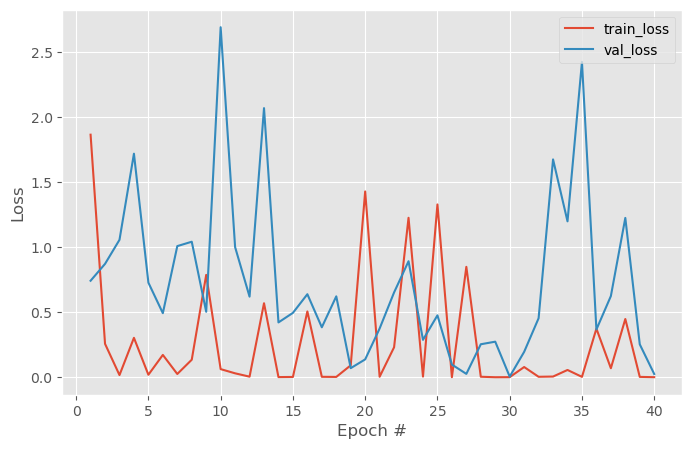

In [122]:
Drawloss(loss_list, val_loss_list)

In [123]:
val_accuracy(model_path)
test_result(model_path, predict_csv_path)

100%|██████████| 8/8 [00:01<00:00,  4.12it/s]


/kaggle/working/ResNetPSPNet_epoch100_kaggle.pt, Val Accuracy: 97.22%


100%|██████████| 10142/10142 [01:30<00:00, 112.19it/s]
